In [37]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [38]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [39]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [40]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_taylor2, load_taylor1a,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [41]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [42]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_test', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_test', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
train_df:  (200, 18)
test_df:  (50, 18)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.9567,-0.9666,22.8365,4.7788
1,ffef_tr_test,-39.0258,-39.8596,54.7667,7.4005
2,ffef_tr2_test,0.4458,0.4430,6.4680,2.5432
3,ffef_tr2_test,-13.4214,-13.7219,19.7326,4.4421
4,Naive_test,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002


# Load Data

In [43]:
taylor_df = load_taylor()
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
train_df:  (200, 18)
test_df:  (50, 18)


In [44]:
taylor_df['chair_name'].unique()

array(['Martin', 'Burns', 'Miller', 'Volcker', 'Greenspan', 'Bernanke',
       'Yellen', 'Powell'], dtype=object)

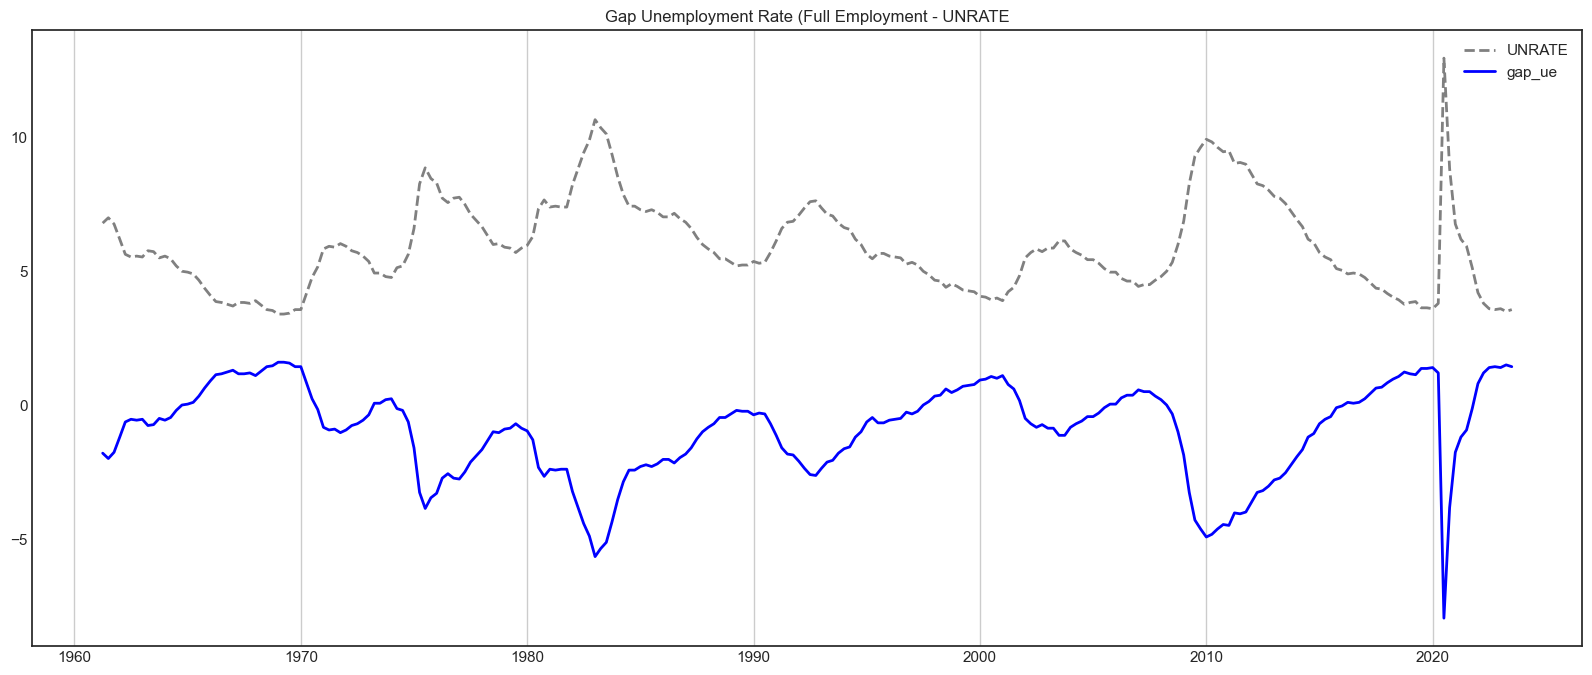

In [45]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['UNRATE'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_ue'], 'blue', linewidth=2)
ax.legend(["UNRATE","gap_ue"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

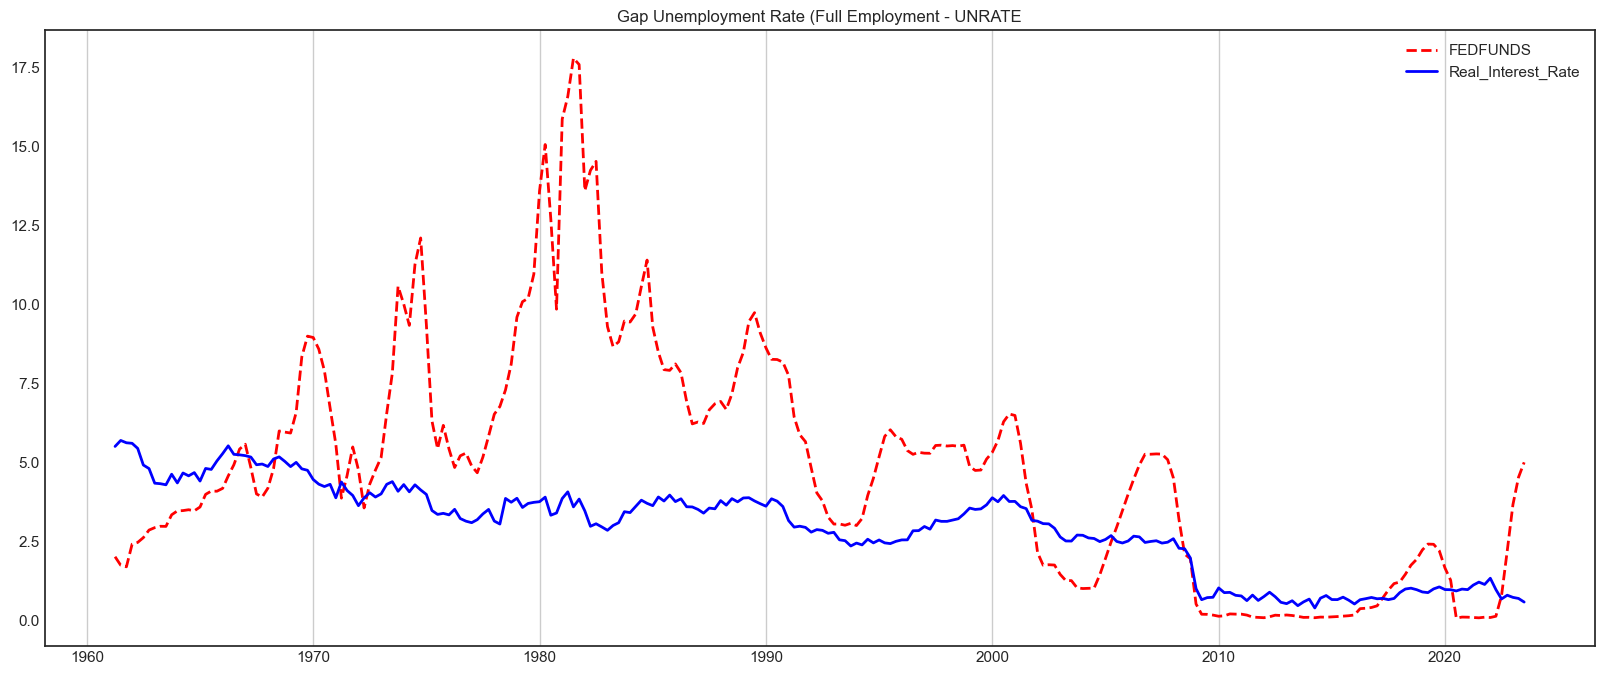

In [46]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'red', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'blue', linewidth=2)
ax.legend(["FEDFUNDS","Real_Interest_Rate"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

In [47]:
X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag','Real_Interest_Rate','gap_ue','chair_name']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag','Real_Interest_Rate','gap_ue','chair_name']]
y_test = test_df['FEDFUNDS']

In [48]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
cat_columns_lst = ['recession_flag','chair_name']
num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_gdp','Real_Interest_Rate','gap_ue']


ohe_categories = list()
for c in cat_columns_lst:
    ohe_categories.append(list(X_train[c].unique()))
    
ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                   sparse_output=False, handle_unknown='ignore')

transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
categorical_transformer = Pipeline( steps=[('transformer',transformer)])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [49]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)

X_train_trf:  (200, 11)


# Stats Model - Taylor Index

In [50]:
X_train_const = sm.add_constant(X_train_trf)

In [51]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     288.6
Date:                Fri, 24 Nov 2023   Prob (F-statistic):          2.34e-111
Time:                        09:03:10   Log-Likelihood:                -241.10
No. Observations:                 200   AIC:                             506.2
Df Residuals:                     188   BIC:                             545.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.0440      0.943     -2.168      0.031      -3.904      -0.184
num__FEDFUNDS-1                              0.8006      0.043     18.440      0.000       0.715       0.886
num__gap_inf                                 0.2454      0.054      4.562      0.000       0.139       0.351
num__gap_gdp                                 0.2259      0.061      3.696      0.000       0.105       0.347
num__Real_Interest_Rate                      0.1991      0.173      1.150      0.252      -0.142       0.541
num__gap_ue                                 -0.1358      0.112     -1.215      0.226      -0.356       0.085
cat__onehotencoder__recession_flag_True     -0.3818      0.222     -1.717      0.088      -0.821       0.057
cat__onehotencoder__chair_name_Burns        -0.0782      0.295     -0.265      0.791      -0.660       0.504
cat__onehotencoder__chair_name_Miller        0.1520      0.473      0.321      0.748      -0.782       1.086
cat__onehotencoder__chair_name_Volcker       1.2582      0.400      3.143      0.002       0.468       2.048
cat__onehotencoder__chair_name_Greenspan     0.6654      0.356      1.868      0.063      -0.037       1.368
cat__onehotencoder__chair_name_Bernanke      0.6415      0.527      1.217      0.225      -0.399       1.682
==============================================================================
Omnibus:                       43.309   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              438.823
Skew:                           0.366   Prob(JB):                     5.14e-96
Kurtosis:                      10.220   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [53]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

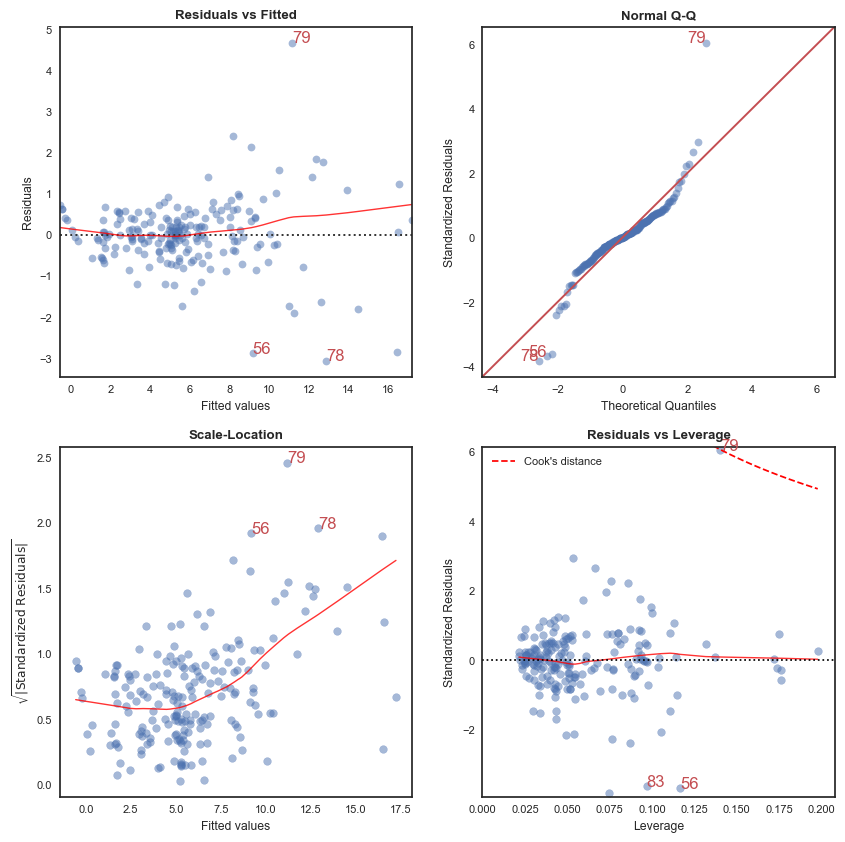

                                    Features  VIF Factor
0                                      const  256.072307
1                            num__FEDFUNDS-1    6.286177
2                               num__gap_inf    4.686685
3                               num__gap_gdp    6.892201
4                    num__Real_Interest_Rate    8.772849
5                                num__gap_ue    8.953374
6    cat__onehotencoder__recession_flag_True    1.664188
7       cat__onehotencoder__chair_name_Burns    3.371733
8      cat__onehotencoder__chair_name_Miller    1.877615
9     cat__onehotencoder__chair_name_Volcker    6.206455
10  cat__onehotencoder__chair_name_Greenspan    8.521737
11   cat__onehotencoder__chair_name_Bernanke    7.208319


In [54]:
cls = LinearRegDiagnostic(ols_result)
vif, fig, ax = cls()
print(vif)

In [55]:
# Get the residuals from the fitted model
residuals = ols_result.resid

# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))

Shapiro-Wilk Test Statistic: 0.8903834223747253
Shapiro-Wilk p-value: 0.0


## Test

In [56]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (50, 12)


In [57]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(50, 6)

In [58]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

# Lasso

In [59]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.03178225849813304


In [60]:
lasso_best = linear_model.Lasso(alpha=model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [61]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,coef
num__FEDFUNDS-1,0.886053
cat__onehotencoder__chair_name_Volcker,0.392010
cat__onehotencoder__recession_flag_True,-0.265383
num__gap_gdp,0.165994
num__gap_inf,0.136377
num__gap_ue,-0.051912
cat__onehotencoder__chair_name_Burns,-0.036913
num__Real_Interest_Rate,-0.000000
cat__onehotencoder__chair_name_Miller,0.000000
cat__onehotencoder__chair_name_Greenspan,0.000000


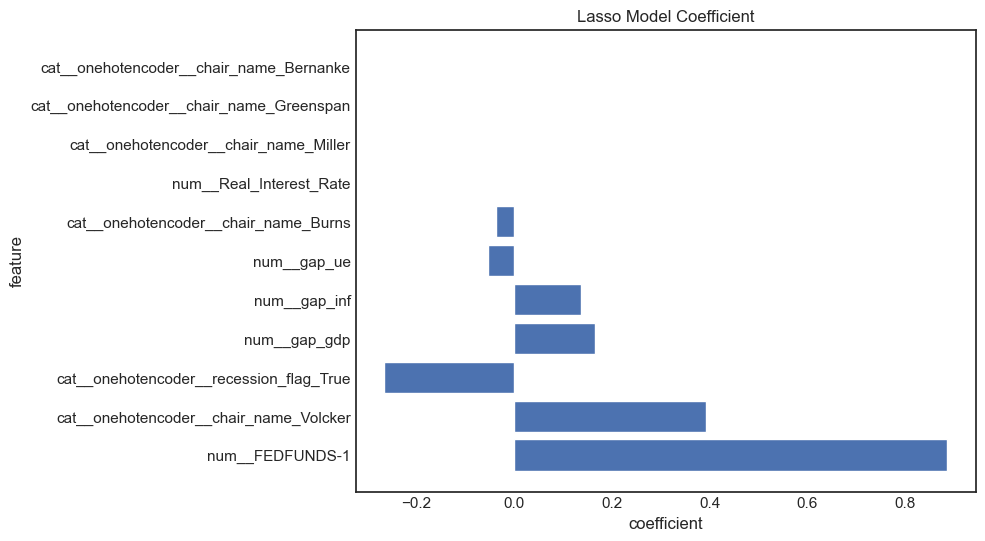

In [62]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

In [63]:
model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], 2 , model_stats_df )

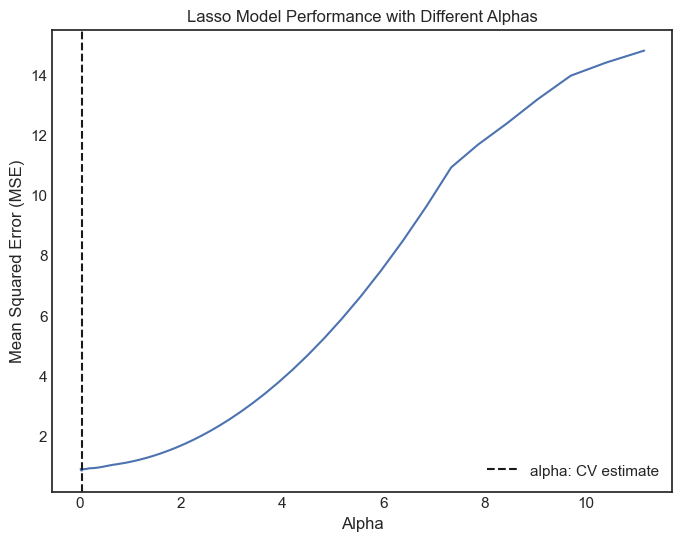

In [64]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

(-0.5462506883166667,
 11.716770381983334,
 -1.3522189838772485,
 30.890941211533836)

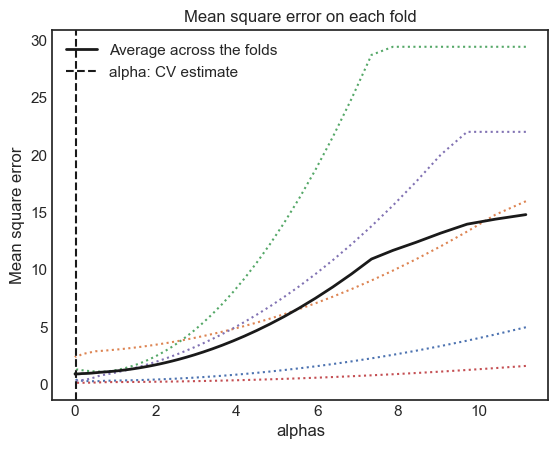

In [65]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

In [66]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (50,)


In [67]:
model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

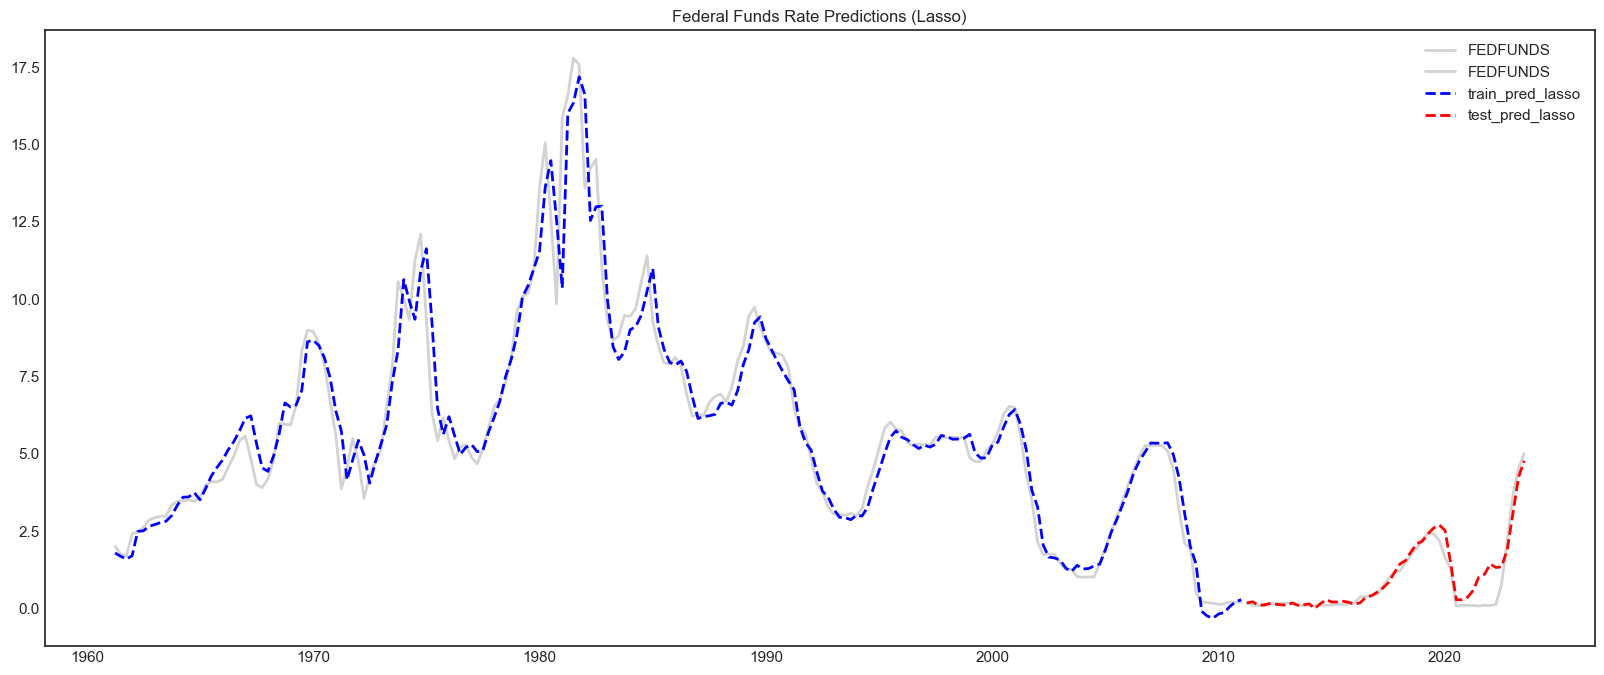

In [68]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

# LGBM

In [69]:
pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)

param_ltb = {
    'model__n_estimators': randint(100, 300), #[100, 200, 300],
    'model__learning_rate': uniform(0.01, 0.5),  #[0.01, 0.05, 0.1, 0.5],
    'model__max_depth': randint(3, 10),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
    'model__eval_metric': ['r2_score'],
}


cv = RandomizedSearchCV(estimator = pipe_ltb, 
                        param_distributions = param_ltb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('LGBMR', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

LGBMR ) Best Accuracy Score: 0.5184097517981308 Parameters: {} {'model__eval_metric': 'r2_score', 'model__learning_rate': 0.020404898976033085, 'model__max_depth': 4, 'model__min_data_in_leaf': 10, 'model__n_estimators': 260, 'model__num_leaves': 49, 'model__reg_alpha': 0.07714526452120027, 'model__verbose': -1}


In [70]:
cv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp_num',
                                                                   SimpleImputer())]),
                                                  ['FEDFUNDS-1', 'gap_inf',
                                                   'gap_gdp',
                                                   'Real_Interest_Rate',
                                                   'gap_ue']),
                                                 ('cat',
                                                  Pipeline(steps=[('transformer',
                                                                   ColumnTransformer(transformers=[('onehotencoder',
                                                                                                    OneHotEncoder(categories=[[False,
                                                                                                                               True],
                                                                                                                              ['Martin',
                                                                                                                               'Burns',
                                                                                                                               'Miller',
                                                                                                                               'Volcker',
                                                                                                                               'Greenspan',
                                                                                                                               'Bernanke']],
                                                                                                                  drop='first',
                                                                                                                  handle_unknown='ignore',
                                                                                                                  sparse_output=False),
                                                                                                    ['recession_flag',
                                                                                                     'chair_name'])]))]),
                                                  ['recession_flag',
                                                   'chair_name'])])),
                ('model',
                 LGBMRegressor(eval_metric='r2_score',
                               learning_rate=0.020404898976033085, max_depth=4,
                               min_data_in_leaf=10, n_estimators=260,
                               num_leaves=49, reg_alpha=0.07714526452120027,
                               verbose=-1))])

In [71]:
cv.best_estimator_.named_steps.model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.020404898976033085,
              max_depth=4, min_data_in_leaf=10, n_estimators=260, num_leaves=49,
              reg_alpha=0.07714526452120027, verbose=-1)

In [72]:
train_pred_lgbm = cv.best_estimator_.predict(X_train, pred_contrib=False, raw_score=False)

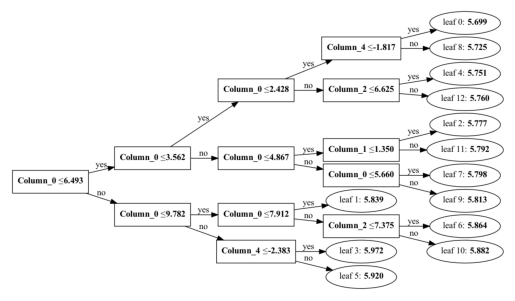

In [73]:
ltb.plot_tree(cv.best_estimator_.named_steps.model)
plt.show()

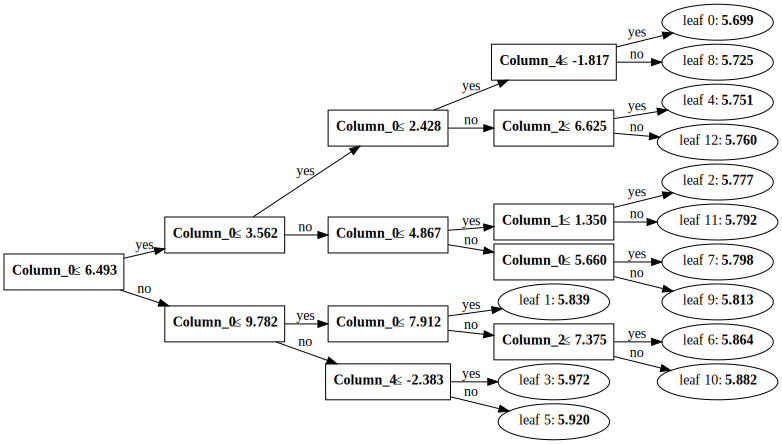

In [74]:
ltb.create_tree_digraph(cv.best_estimator_.named_steps.model)

In [75]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.named_steps.preprocessor.get_feature_names_out(),
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})
feature_df.sort_values(by=['feature_importance'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,feature_name,feature_importance
0,num__FEDFUNDS-1,899
2,num__gap_gdp,409
1,num__gap_inf,388
3,num__Real_Interest_Rate,238
4,num__gap_ue,155
8,cat__onehotencoder__chair_name_Volcker,83
5,cat__onehotencoder__recession_flag_True,26
10,cat__onehotencoder__chair_name_Bernanke,10
9,cat__onehotencoder__chair_name_Greenspan,4
6,cat__onehotencoder__chair_name_Burns,0


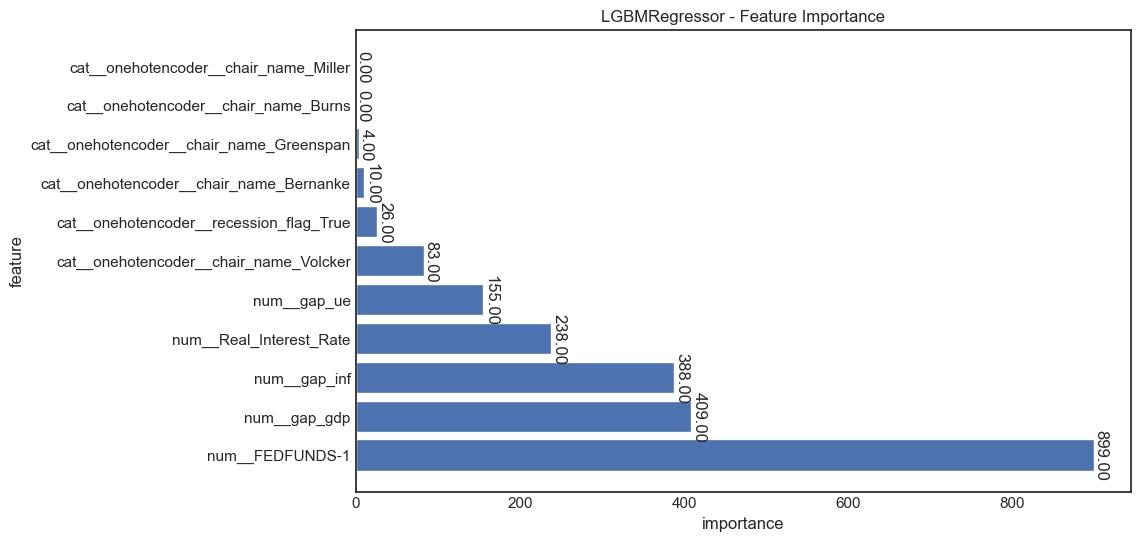

In [76]:
plt.figure(figsize=(10, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('LGBMRegressor - Feature Importance')
plt.grid(False)
plt.show()

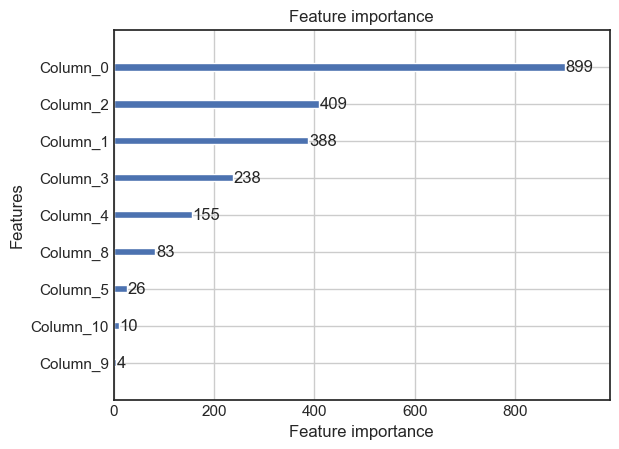

In [77]:
ltb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [78]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1] , model_stats_df )

In [79]:
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.9567,-0.9666,22.8365,4.7788
1,ffef_tr_test,-39.0258,-39.8596,54.7667,7.4005
2,ffef_tr2_test,0.4458,0.4430,6.4680,2.5432
3,ffef_tr2_test,-13.4214,-13.7219,19.7326,4.4421
4,Naive_test,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002
6,ols_train,0.9441,0.9424,0.6525,0.8078
7,ols_test,0.6157,0.5621,0.5258,0.7251
8,lasso_train,0.9401,0.9398,0.6990,0.8360
9,lasso_test,0.8872,0.8582,0.1544,0.3929


# Sharpe

In [80]:
model = cv.best_estimator_.named_steps.model
model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.020404898976033085,
              max_depth=4, min_data_in_leaf=10, n_estimators=260, num_leaves=49,
              reg_alpha=0.07714526452120027, verbose=-1)

In [81]:
explainer = None
shap_values = None

In [82]:
try:
    explainer = shap.Explainer(model, X_train_trf)
    shap_values = explainer(X_train_trf)
except Exception as e:
    print('-- error ')
    print(e)

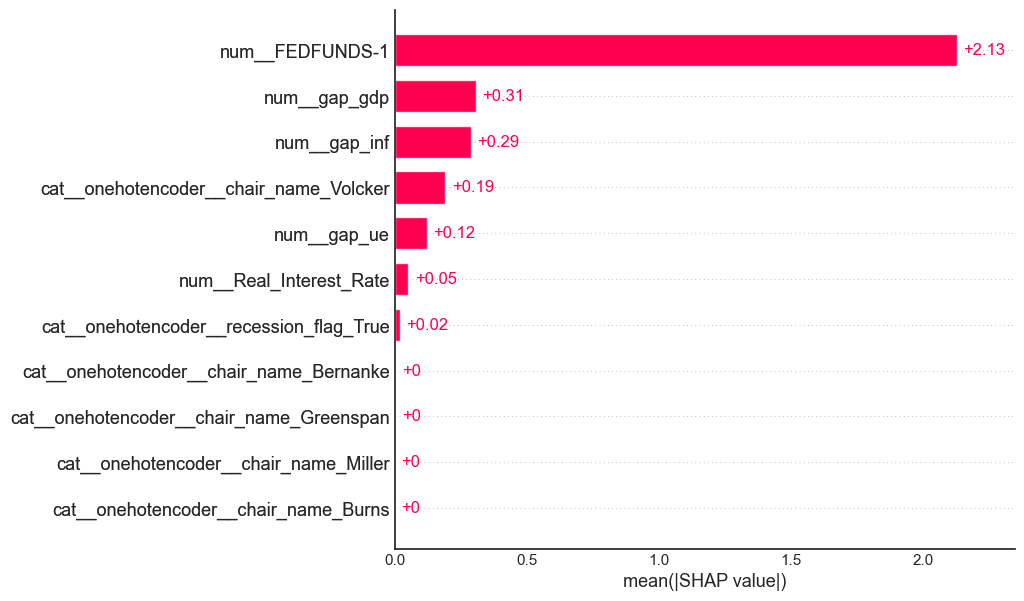

In [83]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

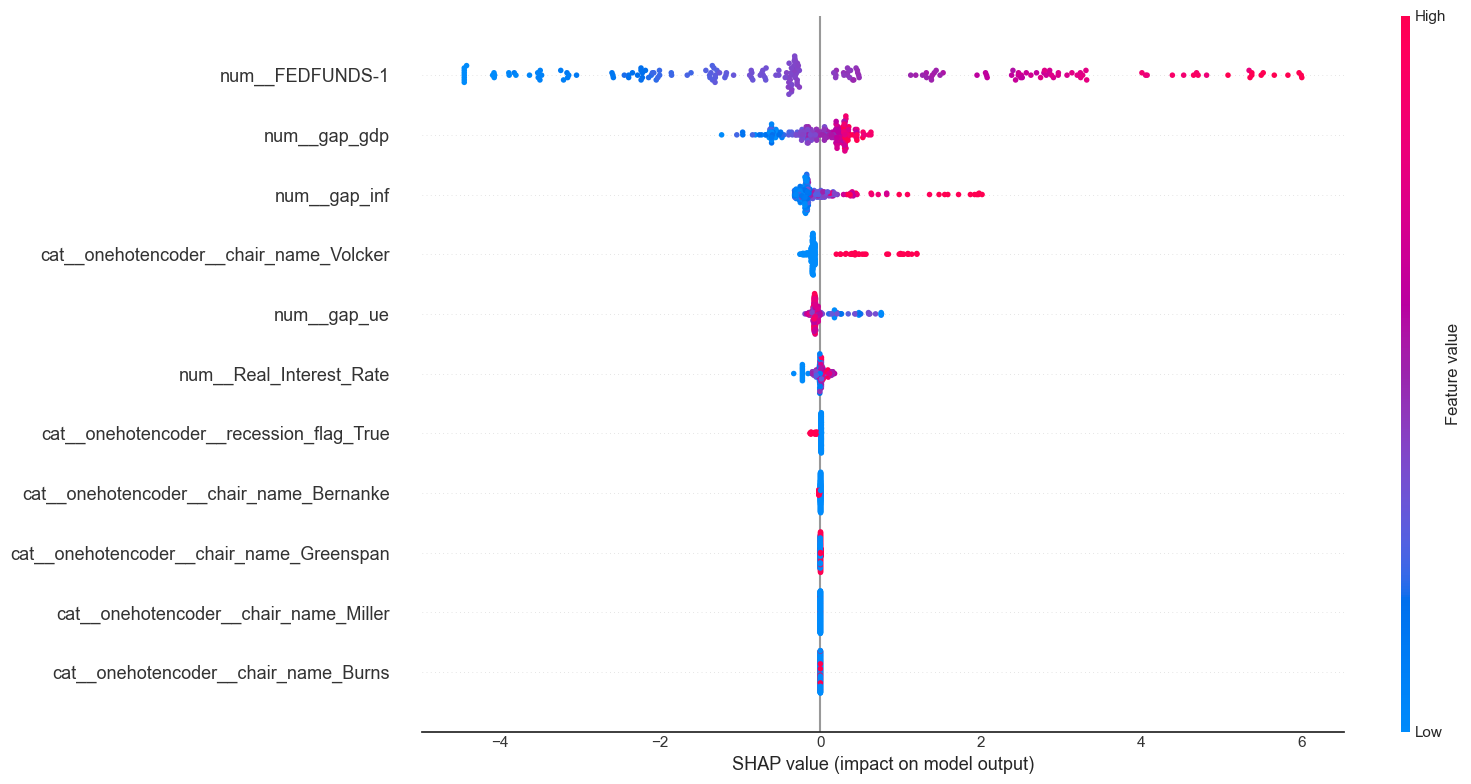

In [84]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_train_trf, plot_size=(16,8))

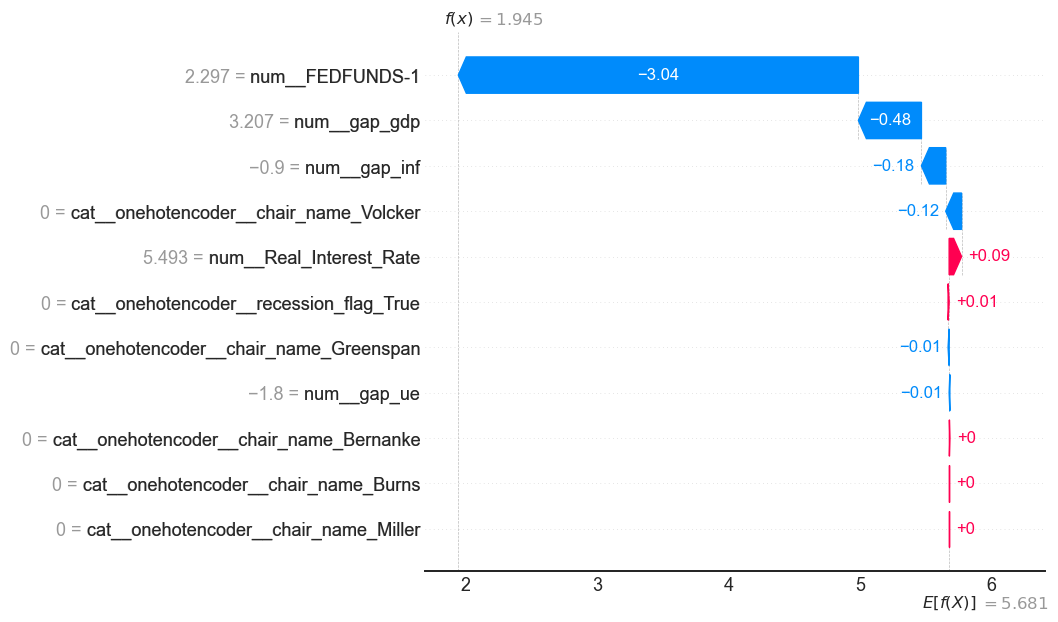

In [85]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


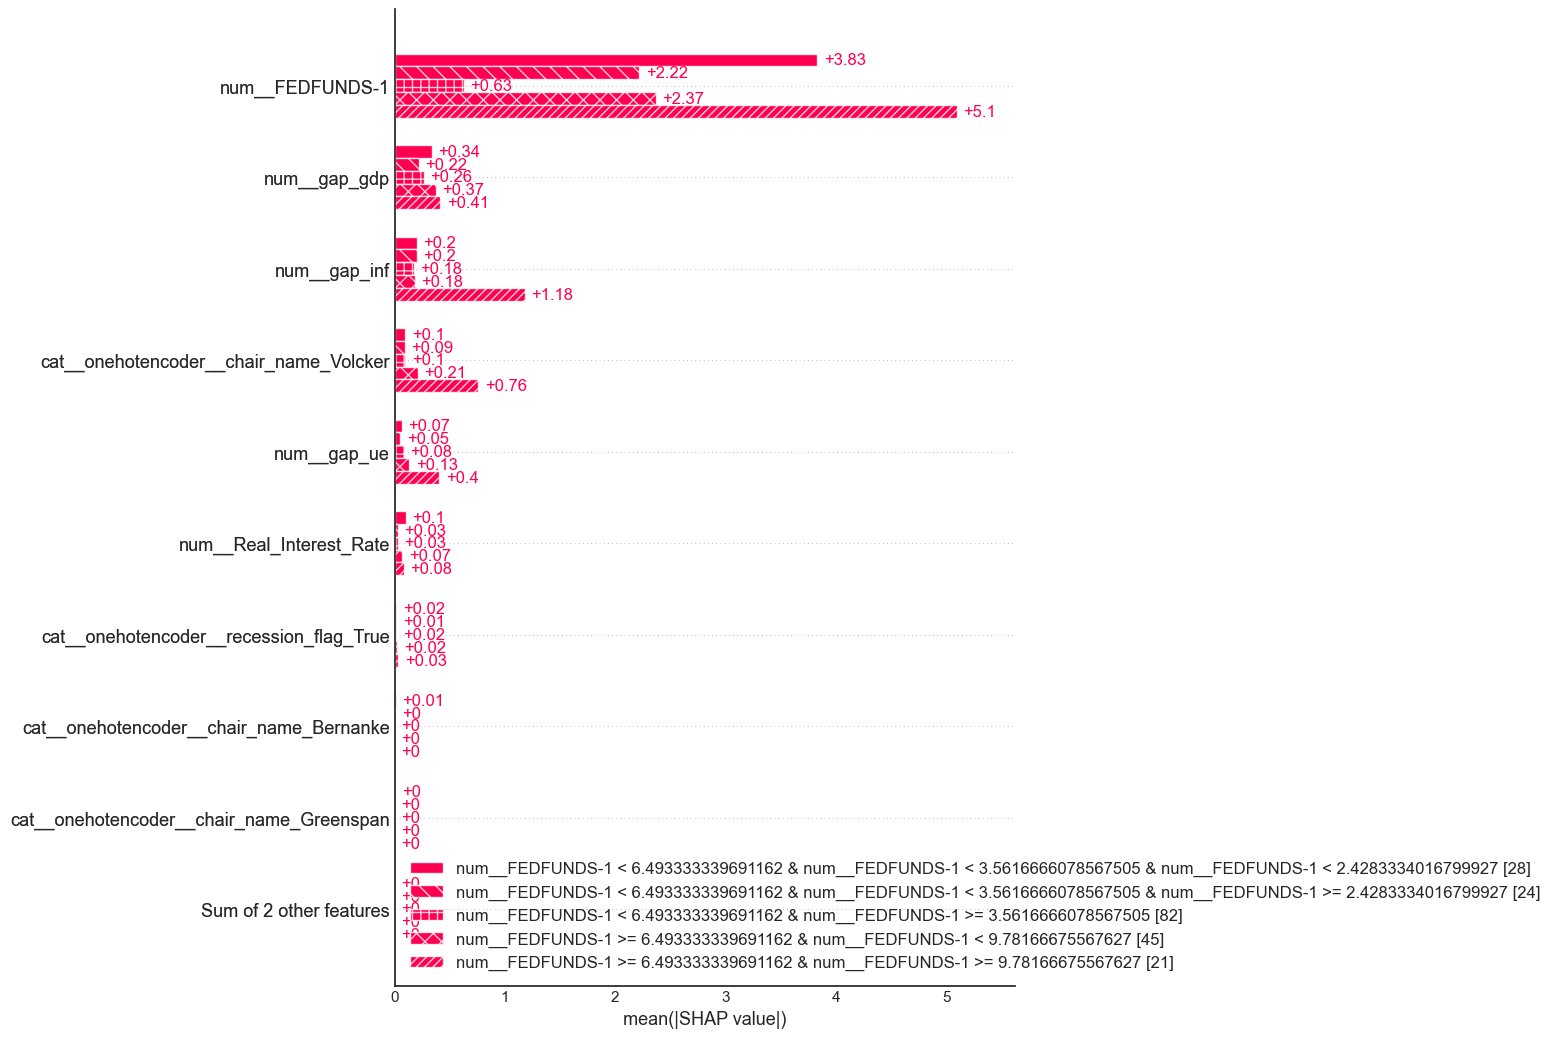

In [86]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)